In [1]:
# Feature engineering and model selection
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Classification metrics and models
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')

# Custom imports to prevent clutter
from helper import *


In [10]:
# Specify window sizes for rolling min-max and z-score scaling
window_sizes = [24, 24 * 7, 24 * 30]

# Specify the symbol ID
symbol_id = 'BTC_USD_COINBASE'

# Pipeline for feature engineering and modeling
feature_engineering_pipeline = Pipeline([

    # Add block-based features to the dataset
    ('block_features', BlockFeatures()),

    # Add transaction-based features to the dataset
    ('transaction_features', TransactionFeatures()),

    # Add transfer-based features to the dataset
    # ('transfer_features', TransferFeatures()),

    # Add tick-based features to the dataset
    ('tick_features', TickFeatures(symbol_id = symbol_id)),

    # Add order book-based features to the dataset
    # ('order_book_features', OrderBookFeatures(symbol_id = symbol_id)),

    # Add network-based features to the dataset
    # ('network_features', NetworkFeatures()),

    # Add wallet-based features to the dataset
    # ('wallet_features', WalletFeatures()),

    # Add price-based features to the dataset
    # ('price_features', PriceFeatures(symbol_id = symbol_id)),

    # Add lagged features to the dataset
    ('lag_features', LagFeatures(lags = [1, 2, 3])),

    # Add rolling min-max scaled features to the dataset
    # ('rolling_min_max_scaler', RollingMinMaxScaler(window_sizes)),

    # Add rolling z-score scaled features to the dataset
    ('rolling_z_score_scaler', RollingZScoreScaler(window_sizes)),

    # Add more feature engineering steps here
    # ...
    # ...

    # Drop columns that are no longer needed
    ('drop_columns', DropColumns()),

    # Add time-based features to the dataset
    ('time_features', TimeFeatures())
])

In [3]:
base, quote, exchange = symbol_id.split('_')

query = """
SELECT
    time_period_end,
    price_open,
    price_high,
    price_low,
    price_close,
    volume_traded
FROM token_price.coinapi.price_data_1h
WHERE 
    asset_id_base = '{}' AND
    asset_id_quote = '{}' AND
    exchange_id = '{}'
ORDER BY time_period_start ASC
""".format(base, quote, exchange)

ohlcv_1h_cols = ['time_period_end', 'price_open', 'price_high', 'price_low', 'price_close', 'volume_traded']
ohlcv_1h = execute_query(
    query = query,
    cols = ohlcv_1h_cols,
    date_col = 'time_period_end'
)

ohlcv_1h.head()

,price_open,price_high,price_low,price_close,volume_traded
time_period_end,,,,,
2015-01-14 17:00:00,173.93,197.97,110.2,185.91,1.050000
2015-01-14 18:00:00,173.93,197.97,110.2,185.91,1.050000
2015-01-14 19:00:00,186.00,186.00,186.0,186.00,0.015362
2015-01-14 20:00:00,186.00,188.00,120.0,120.00,0.264638
2015-01-14 21:00:00,186.00,188.00,120.0,120.00,0.264638


In [11]:
# Fit feature engineering pipeline on OHLCV data
X = feature_engineering_pipeline.fit_transform(ohlcv_1h)

# Calculate triple barrier labels from OHLCV data
y = calculate_triple_barrier_labels(ohlcv_1h, atr_window = 24, max_holding_time = 24)

# Align X and y
X = X[X.index.isin(y.index)]
y = y[y.index.isin(X.index)]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False, test_size = 0.2)

# Print shapes of train and test sets
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print()
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)


X_train shape:  (4122, 589)
y_train shape:  (4122,)

X_test shape:  (1031, 589)
y_test shape:  (1031,)


In [20]:
%%time

# Grid search parameters
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 5, 10],
    'max_features': ['sqrt'],
}

# Random forest classifier
rf = RandomForestClassifier(bootstrap = False, random_state = 9 + 10)

# Grid search
grid_search = GridSearchCV(
    rf, 
    param_grid, 
    # Split data using time-based cross-validation to avoid data leakage
    cv = TimeSeriesSplit(n_splits = 3), 
    scoring = 'f1',
    verbose = 1, 
    n_jobs = -1
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print()
print('Best parameters: ', best_params)
print()

Fitting 3 folds for each of 81 candidates, totalling 243 fits

Best parameters:  {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 50}

CPU times: user 1.98 s, sys: 120 ms, total: 2.1 s
Wall time: 53.4 s


Train Classification Report

              precision    recall  f1-score   support

        -1.0       0.80      0.64      0.71      1965
         1.0       0.72      0.85      0.78      2157

    accuracy                           0.75      4122
   macro avg       0.76      0.75      0.75      4122
weighted avg       0.76      0.75      0.75      4122

Train Accuracy:  0.7533
Train Precision:  0.7603
Train Recall:  0.7533
Train F1 Score:  0.75
Train ROC AUC Score:  0.7484


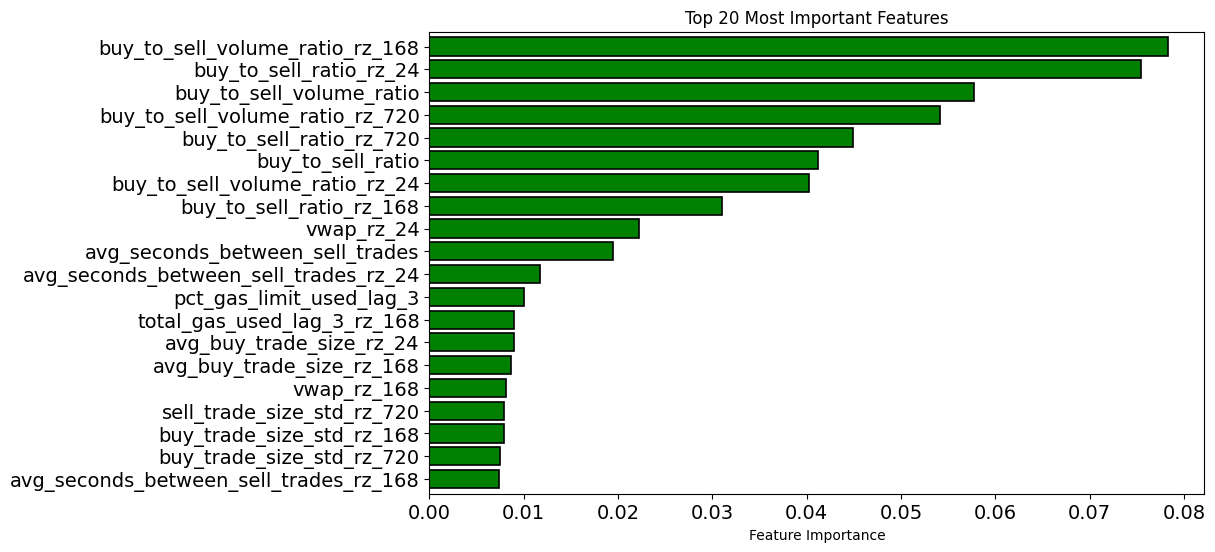

In [21]:
# Train Predictions
y_pred = best_model.predict(X_train)

# Classification report
print('Train Classification Report')
print()
print(classification_report(y_train, y_pred))

# Various metrics rounded to 4 decimal places
accuracy = round(accuracy_score(y_train, y_pred), 4)
precision = round(precision_score(y_train, y_pred, average = 'weighted'), 4)
recall = round(recall_score(y_train, y_pred, average = 'weighted'), 4)
f1 = round(f1_score(y_train, y_pred, average = 'weighted'), 4)
roc_auc = round(roc_auc_score(y_train, y_pred, average = 'weighted'), 4)

# Print various metrics
print('Train Accuracy: ', accuracy)
print('Train Precision: ', precision)
print('Train Recall: ', recall)
print('Train F1 Score: ', f1)
print('Train ROC AUC Score: ', roc_auc)

# Plot horizontal bar plot of top 20 most important features using Pandas
# w/ labels
feature_importances = pd.Series(best_model.feature_importances_, index = X_train.columns)
feature_importances.nlargest(20).sort_values().plot(
    kind = 'barh', 
    figsize = (10, 6), 
    title = 'Top 20 Most Important Features',
    color = 'green',
    xlabel = 'Feature Importance',
    fontsize = 14,
    width = 0.8,
    edgecolor = 'black',
    linewidth = 1.2
)
plt.show()


In [22]:
# Test predictions
y_pred = best_model.predict(X_test)

# Classification report
print('Test Classification Report')
print()
print(classification_report(y_test, y_pred))

# Various metrics rounded to 4 decimal places
accuracy = round(accuracy_score(y_test, y_pred), 4)
precision = round(precision_score(y_test, y_pred, average = 'weighted'), 4)
recall = round(recall_score(y_test, y_pred, average = 'weighted'), 4)
f1 = round(f1_score(y_test, y_pred, average = 'weighted'), 4)
roc_auc = round(roc_auc_score(y_test, y_pred, average = 'weighted'), 4)

# Print various metrics
print('Test Accuracy: ', accuracy)
print('Test Precision: ', precision)
print('Test Recall: ', recall)
print('Test F1 Score: ', f1)
print('Test ROC AUC Score: ', roc_auc)

Test Classification Report

              precision    recall  f1-score   support

        -1.0       0.70      0.45      0.55       480
         1.0       0.64      0.83      0.72       551

    accuracy                           0.65      1031
   macro avg       0.67      0.64      0.63      1031
weighted avg       0.66      0.65      0.64      1031

Test Accuracy:  0.6537
Test Precision:  0.6637
Test Recall:  0.6537
Test F1 Score:  0.6401
Test ROC AUC Score:  0.6409
